In [237]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [238]:
plt.rcParams["figure.dpi"] = 120

In [239]:
data_dir = "../data"

In [ ]:
# # uncertainty_measure = "prompt_gradient"
# # uncertainty_measure = "rephrased_gradient_std"
# uncertainty_measure = "rephrased_gradient"

In [ ]:
# df_paths = {
#     "AG-Pubmed 100": {
#         "Rephrase": [
#             (
#                 "II Medical",
#                 "Medicine",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl",
#                     f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl",
#                 ),
#             ),
#             (
#                 "MedReason",
#                 "Medicine",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2652_medreason_4bit_rephrase_ag-pubmed.pkl",
#                     f"{data_dir}/full/domainspecific_results_2653_huatougpt_4bit_rephrase_ag-pubmed.pkl",
#                 ),
#             ),
#             (
#                 "Llama 2 Medicine",
#                 "Medicine",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2614_medicine-chat_4bit_rephrase_ag-pubmed.pkl",
#                     f"{data_dir}/full/domainspecific_results_2615_llama-2-chat_4bit_rephrase_ag-pubmed.pkl",
#                 ),
#             ),
#             (
#                 "Medicine Llama 3",
#                 "Medicine",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
#                     f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
#                 ),
#             ),
#         ]
#     },
#     "FineFineWeb 100": {
#         "Rephrase": [
#             (
#                 "II Medical",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "MedReason",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2877_medreason_4bit_rephrase_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_2878_huatougpt_4bit_rephrase_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Llama 2 Medicine",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2941_medicine-chat_4bit_rephrase_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_2942_llama-2-chat_4bit_rephrase_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Medicine Llama 3",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl",
#                 ),
#             ),
#         ],
#         "Synonym": [
#             (
#                 "II Medical",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3064_ii-medical_4bit_synonym_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3065_qwen2.5-7b-instruct_4bit_synonym_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "MedReason",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3066_medreason_4bit_synonym_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3067_huatougpt_4bit_synonym_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Llama 2 Medicine",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3005_medicine-chat_4bit_synonym_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3006_llama-2-chat_4bit_synonym_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Medicine Llama 3",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3003_medicine-llama-3-8b_4bit_synonym_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3004_llama-3-8b_4bit_synonym_finefineweb.pkl",
#                 ),
#             ),
#         ],
#         "Random": [
#             (
#                 "II Medical",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3068_ii-medical_4bit_random_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3069_qwen2.5-7b-instruct_4bit_random_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "MedReason",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3070_medreason_4bit_random_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3071_huatougpt_4bit_random_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Llama 2 Medicine",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3022_medicine-chat_4bit_random_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3023_llama-2-chat_4bit_random_finefineweb.pkl",
#                 ),
#             ),
#             (
#                 "Medicine Llama 3",
#                 "medical",
#                 (
#                     f"{data_dir}/full/domainspecific_results_3020_medicine-llama-3-8b_4bit_random_finefineweb.pkl",
#                     f"{data_dir}/full/domainspecific_results_3021_llama-3-8b_4bit_random_finefineweb.pkl",
#                 ),
#             ),
#         ],
#     },
#     # "AG-Pubmed 1000": [
#     #     (
#     #         "II Medical",
#     #         "Medicine",
#     #         (
#     #             f"{data_dir}/full/domainspecific_results_2537_ii-medical_4bit_rephrase_ag-pubmed.pkl",
#     #             f"{data_dir}/full/domainspecific_results_2539_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl",
#     #         ),
#     #     ),
#     # ],
# }

In [ ]:
# dfs = {}
# for combination, combination_dfs in df_paths.items():
#     dfs[combination] = {}
#     for measure, measure_dfs in combination_dfs.items():
#         dfs[combination][measure] = []
#         for name, trained_label, (path1, path2) in measure_dfs:
#             df1 = pd.read_pickle(path1)
#             df2 = pd.read_pickle(path2)

#             df1["id"] = df1["prompt"].apply(lambda x: hash(x))
#             df2["id"] = df2["prompt"].apply(lambda x: hash(x))

#             if uncertainty_measure == "rephrased_gradient":
#                 df1["rephrased_gradient"] = df1["rephrased_gradients"].apply(
#                     lambda rows: np.mean(rows)
#                 )
#                 df2["rephrased_gradient"] = df2["rephrased_gradients"].apply(
#                     lambda rows: np.mean(rows)
#                 )

#             df1.rename(
#                 columns={
#                     uncertainty_measure: "uncertainty_after",
#                 },
#                 inplace=True,
#             )
#             df2.rename(
#                 columns={
#                     uncertainty_measure: "uncertainty_before",
#                 },
#                 inplace=True,
#             )

#             df = pd.merge(
#                 df1[["prompt", "uncertainty_after", "label", "id"]],
#                 df2[["uncertainty_before", "id"]],
#                 on="id",
#             )

#             df.dropna(
#                 subset=["uncertainty_before", "uncertainty_after"],
#                 inplace=True,
#             )
#             df["uncertainty_difference"] = (
#                 df["uncertainty_after"] - df["uncertainty_before"]
#             )
#             df["uncertainty_difference_relative"] = df["uncertainty_difference"] / df[
#                 "uncertainty_before"
#             ].replace([np.inf, -np.inf], np.nan)
#             df["uncertainty_ratio"] = (
#                 df["uncertainty_after"] / df["uncertainty_before"]
#             ).replace([np.inf, -np.inf], np.nan)

#             dfs[combination][measure].append(
#                 (
#                     name,
#                     trained_label,
#                     df,
#                 )
#             )

In [ ]:
# def plot(dfs):
#     plt_width = 4
#     plt_height = 6

#     x_plots = len(dfs)
#     y_plots = 4

#     fig, axs = plt.subplots(
#         y_plots,
#         x_plots,
#         figsize=(x_plots * plt_width, y_plots * plt_height),
#         squeeze=False,
#     )

#     for i in range(len(dfs)):
#         name, trained_label, df = dfs[i]
        
#         df_melted = df[["label", "uncertainty_before", "uncertainty_after"]].melt(
#             id_vars=["label"],
#             value_vars=["uncertainty_before", "uncertainty_after"],
#             var_name="type",
#             value_name="uncertainty",
#         )
#         df_melted["type"] = df_melted["type"].map(
#             {
#                 "uncertainty_before": "Before",
#                 "uncertainty_after": "After",
#             }
#         )

#         # Create the barplots as before
#         sns.barplot(
#             data=df_melted, x="label", y="uncertainty", hue="type", ax=axs[0][i]
#         )
#         sns.barplot(data=df, x="label", y="uncertainty_difference", ax=axs[1][i])
#         sns.barplot(
#             data=df, x="label", y="uncertainty_difference_relative", ax=axs[2][i]
#         )
#         sns.barplot(data=df, x="label", y="uncertainty_ratio", ax=axs[3][i])

#         # Get the x-tick positions and labels
#         for row_idx, ax in enumerate(axs.T[i]):
#             x_ticks = ax.get_xticks()
#             x_labels = [text.get_text() for text in ax.get_xticklabels()]

#             # Find the position of the trained_label
#             trained_pos = -1
#             for pos, label in enumerate(x_labels):
#                 if label == trained_label:
#                     trained_pos = pos
#                     break

#             if trained_pos != -1:
#                 # For each bar, check if its center is close to the trained_label tick position
#                 for bar in ax.patches:
#                     # Calculate bar center
#                     bar_center = bar.get_x() + bar.get_width() / 2

#                     # If bar center is close to the trained_label tick, hatch it
#                     if abs(bar_center - x_ticks[trained_pos]) < 0.5:
#                         bar.set_hatch("////")

#             ax.tick_params(axis="x", labelrotation=90)
#             ax.set_title(name)

#     # fig.suptitle('This is a somewhat long figure title', fontsize=16)
#     # fig.subplots_adjust(top=0.88)
    
#     plt.tight_layout()


# def t_tests(dfs, metric):
#     for name, trained_label, df in dfs:
#         trained_group = df[df["label"] == trained_label][metric]
#         other_groups = df[df["label"] != trained_label][metric]

#         t_stat, p_value = ttest_ind(trained_group, other_groups, equal_var=False)

#         print(
#             f"{name:<10} {trained_label} vs Others T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
#         )

#     print()

#     for name, trained_label, df in dfs:
#         trained_group = df[df["label"] == trained_label][metric]

#         labels = df["label"].unique()

#         for label in labels:
#             if label != trained_label:
#                 other_group = df[df["label"] == label][metric]
#                 t_stat, p_value = ttest_ind(trained_group, other_group, equal_var=False)
#                 print(
#                     f"{name:<10} {trained_label} vs {label:<10} T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
#                 )

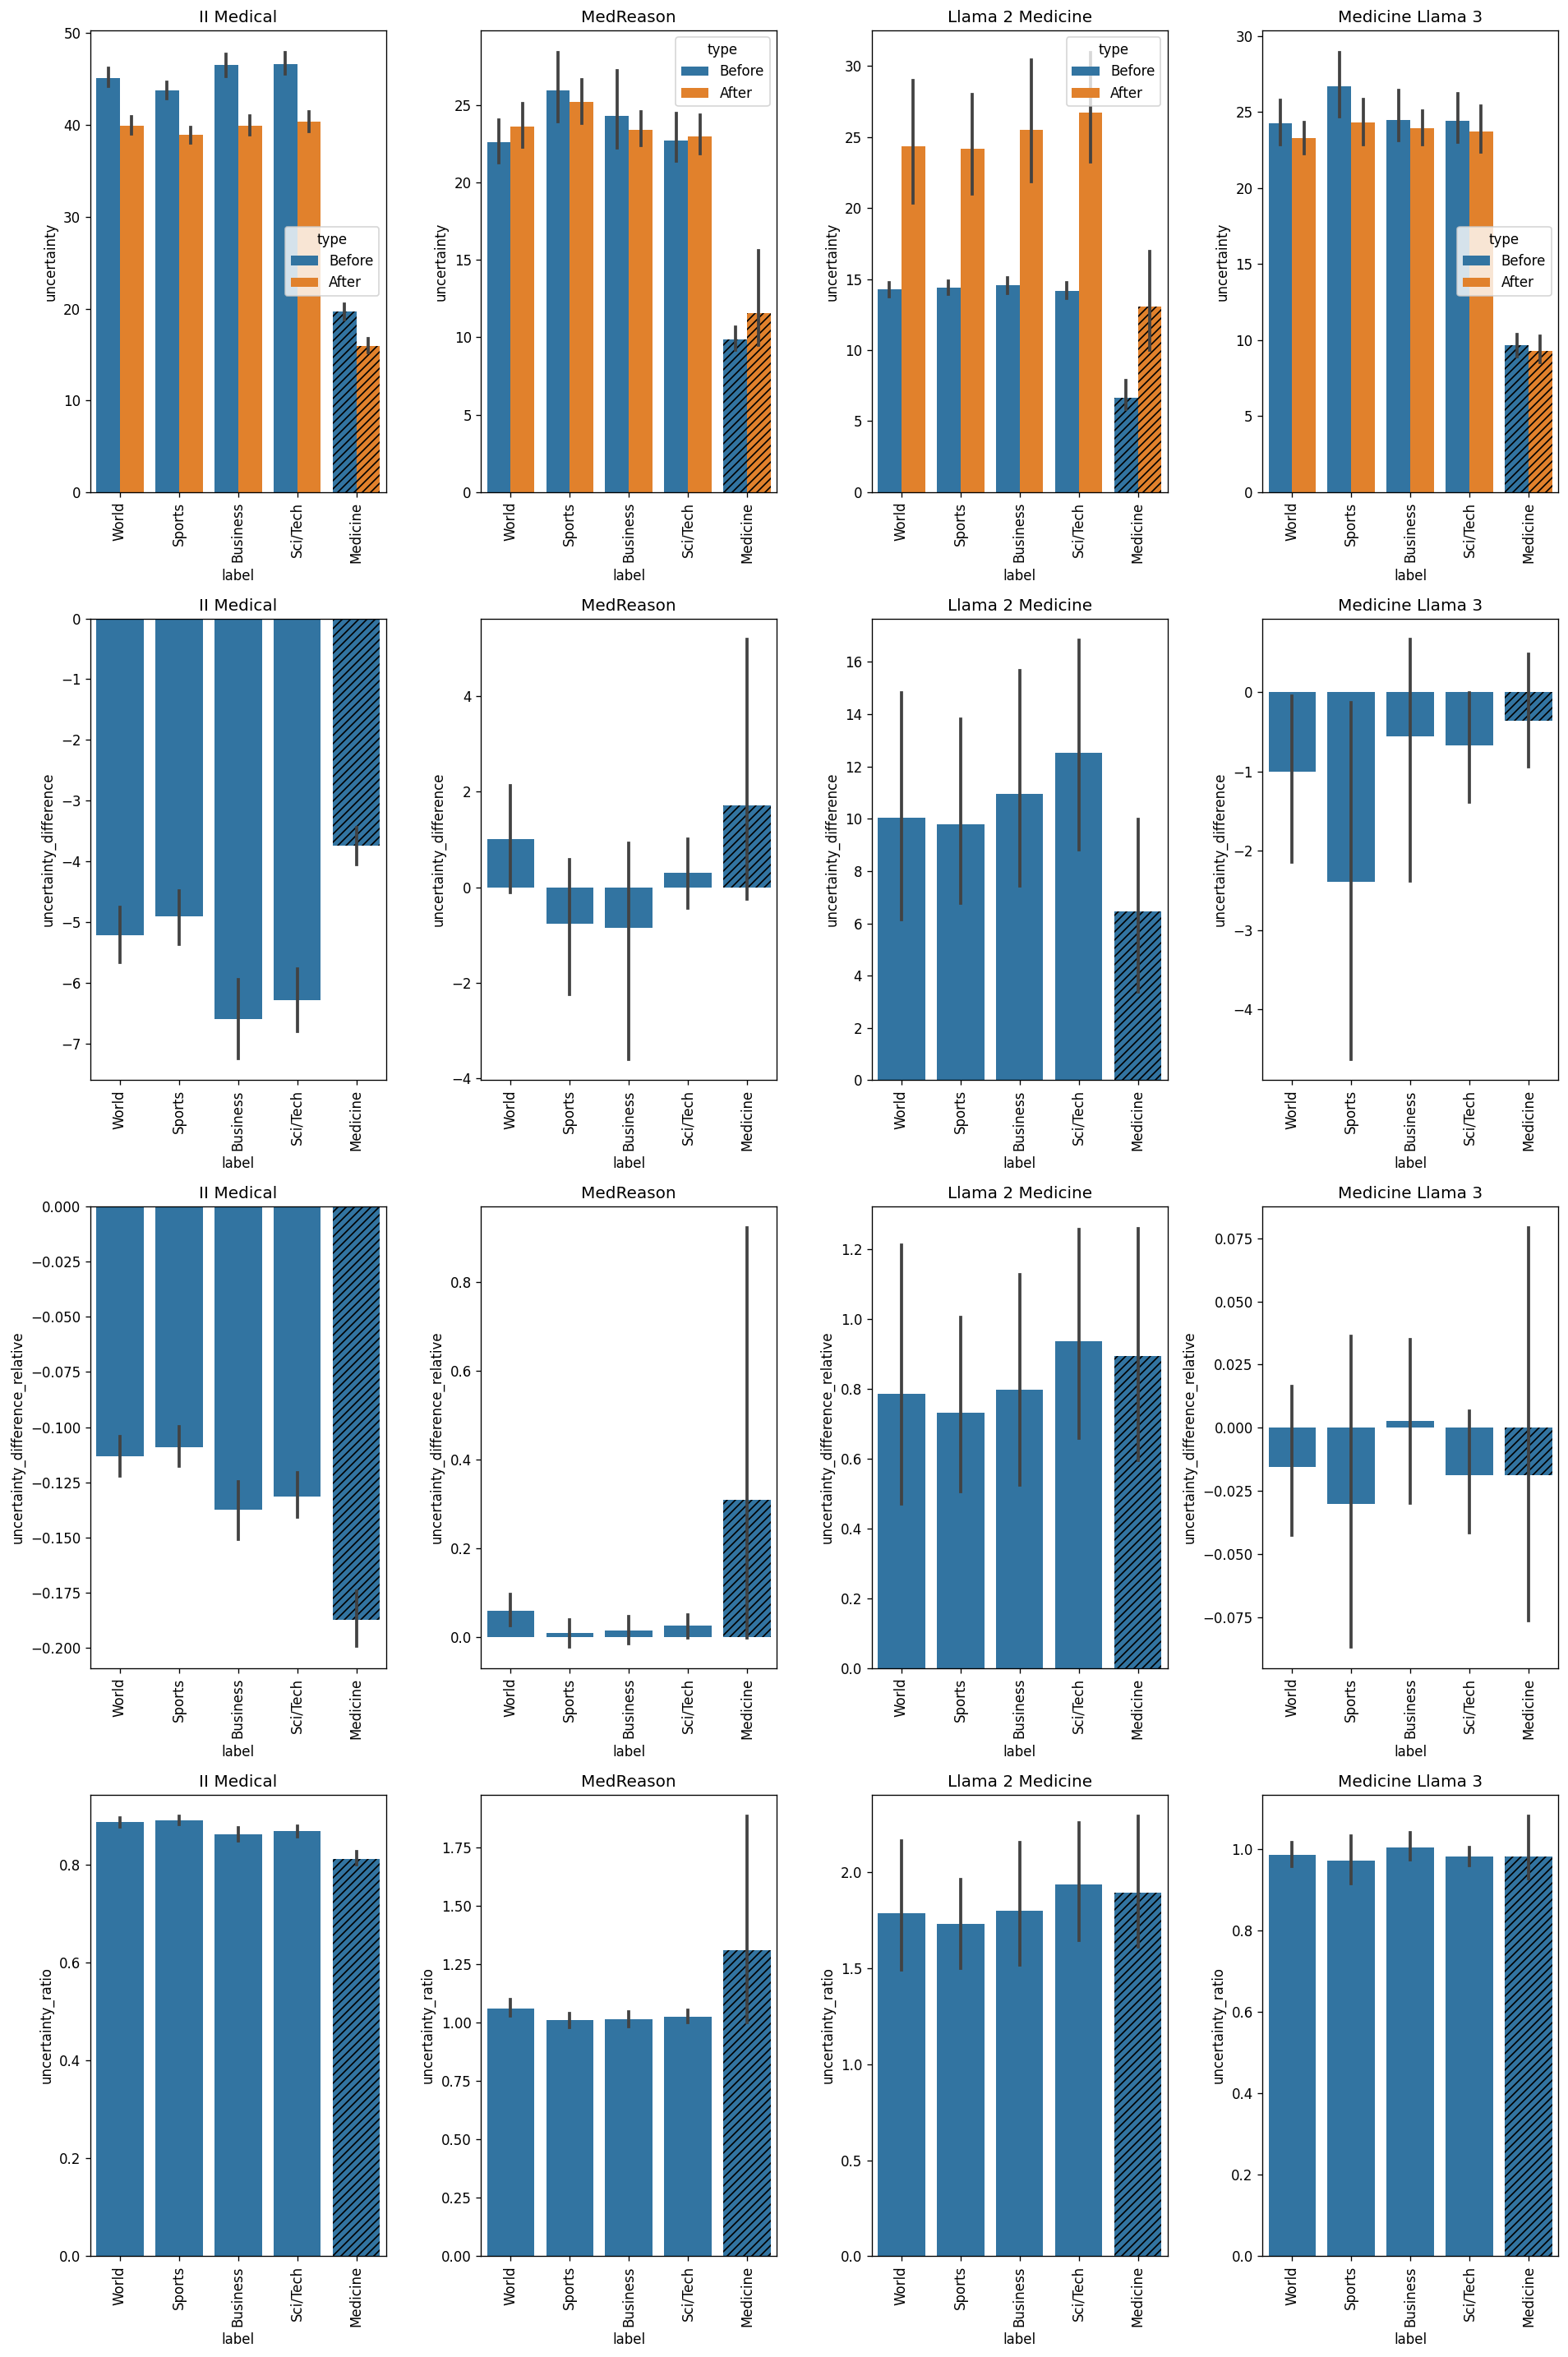

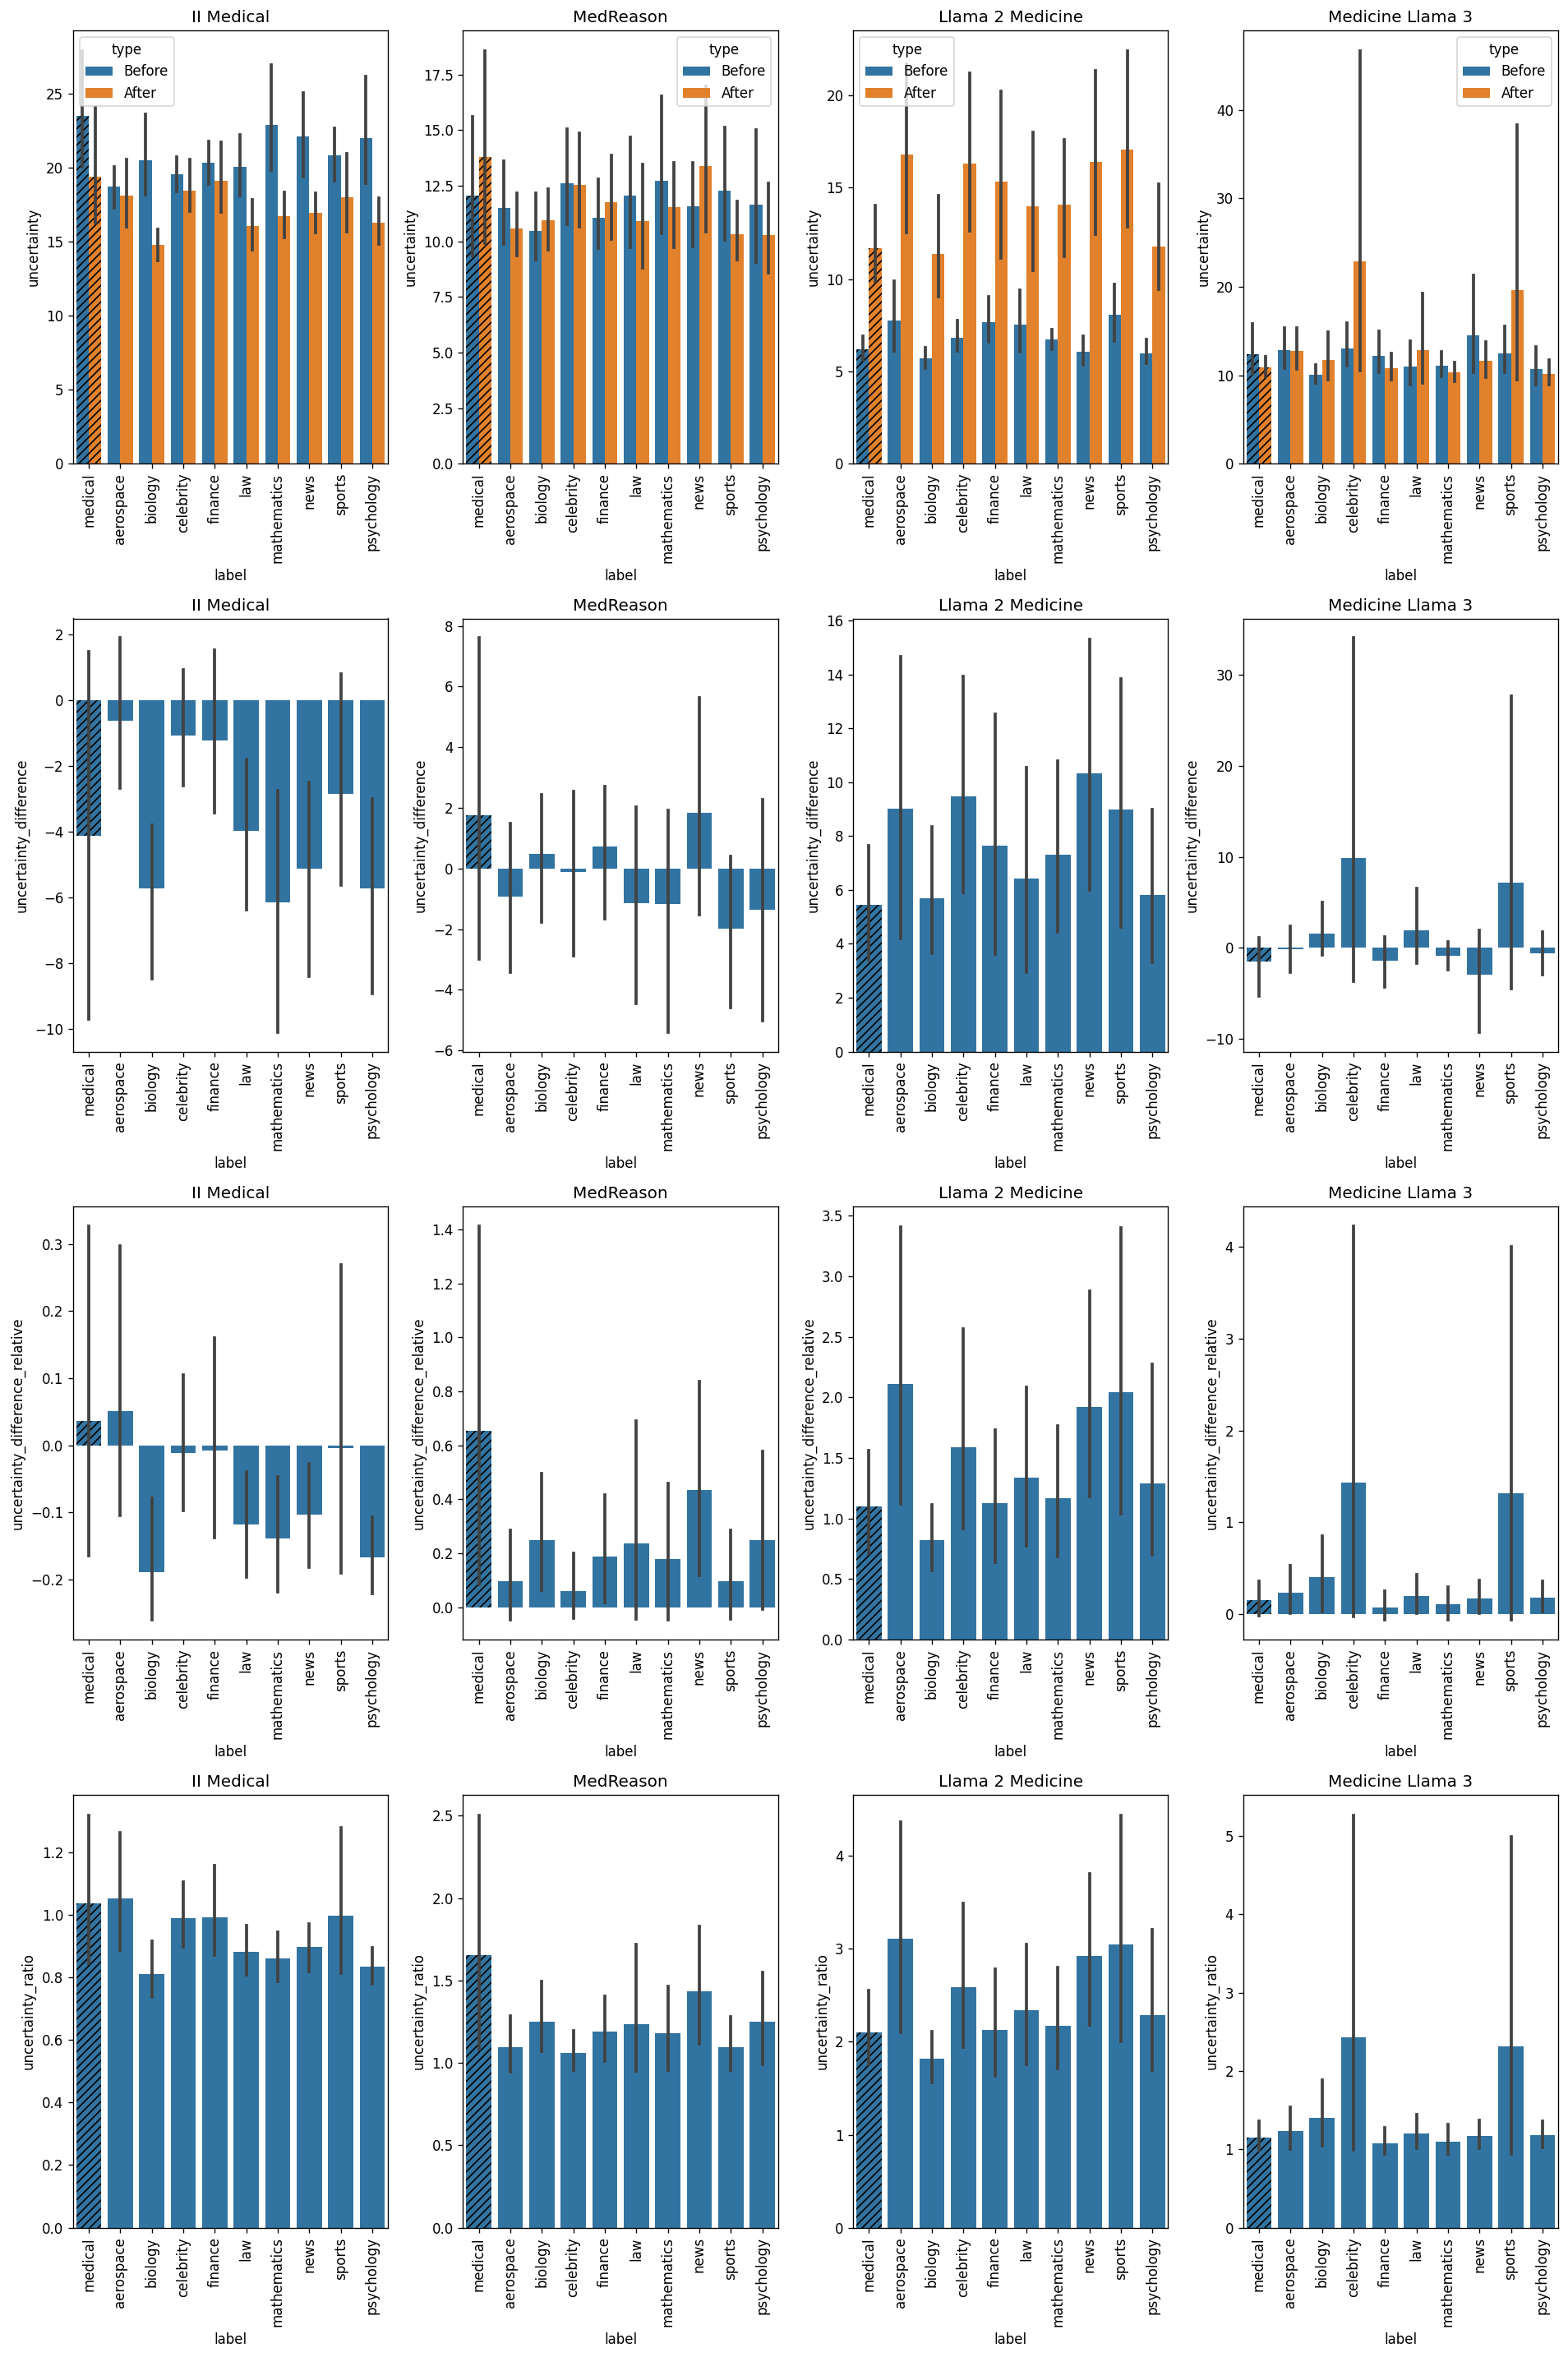

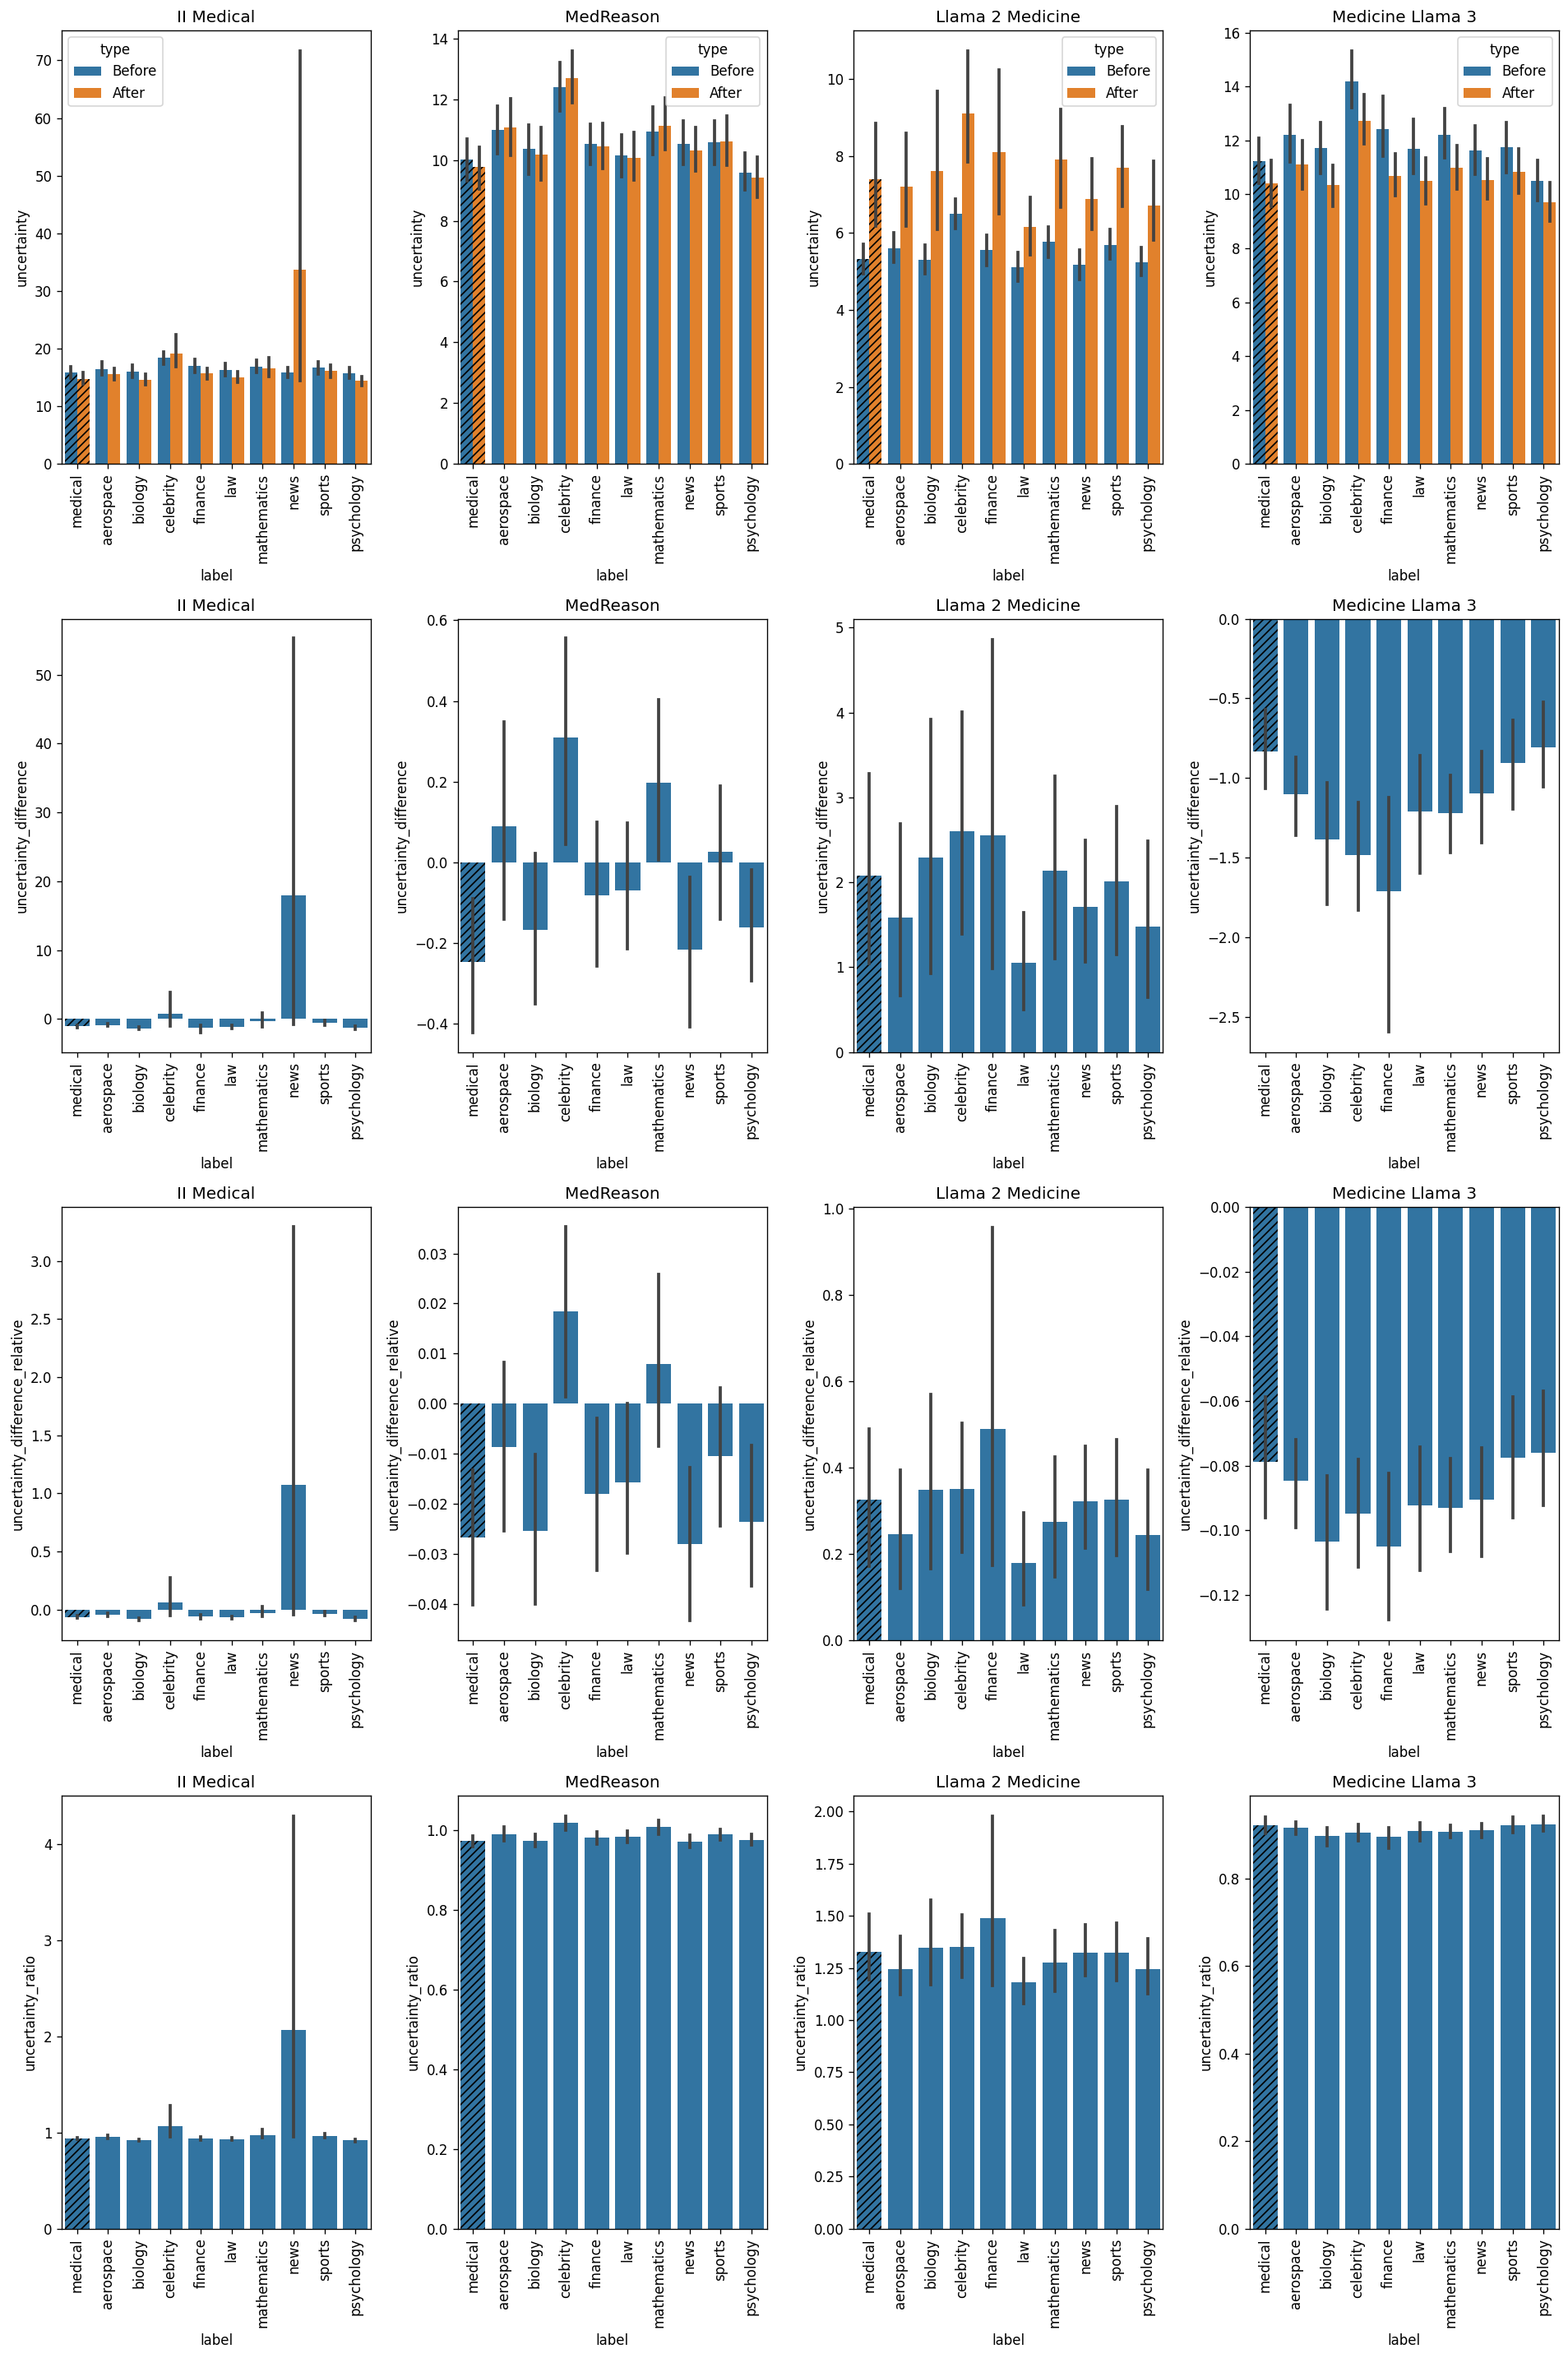

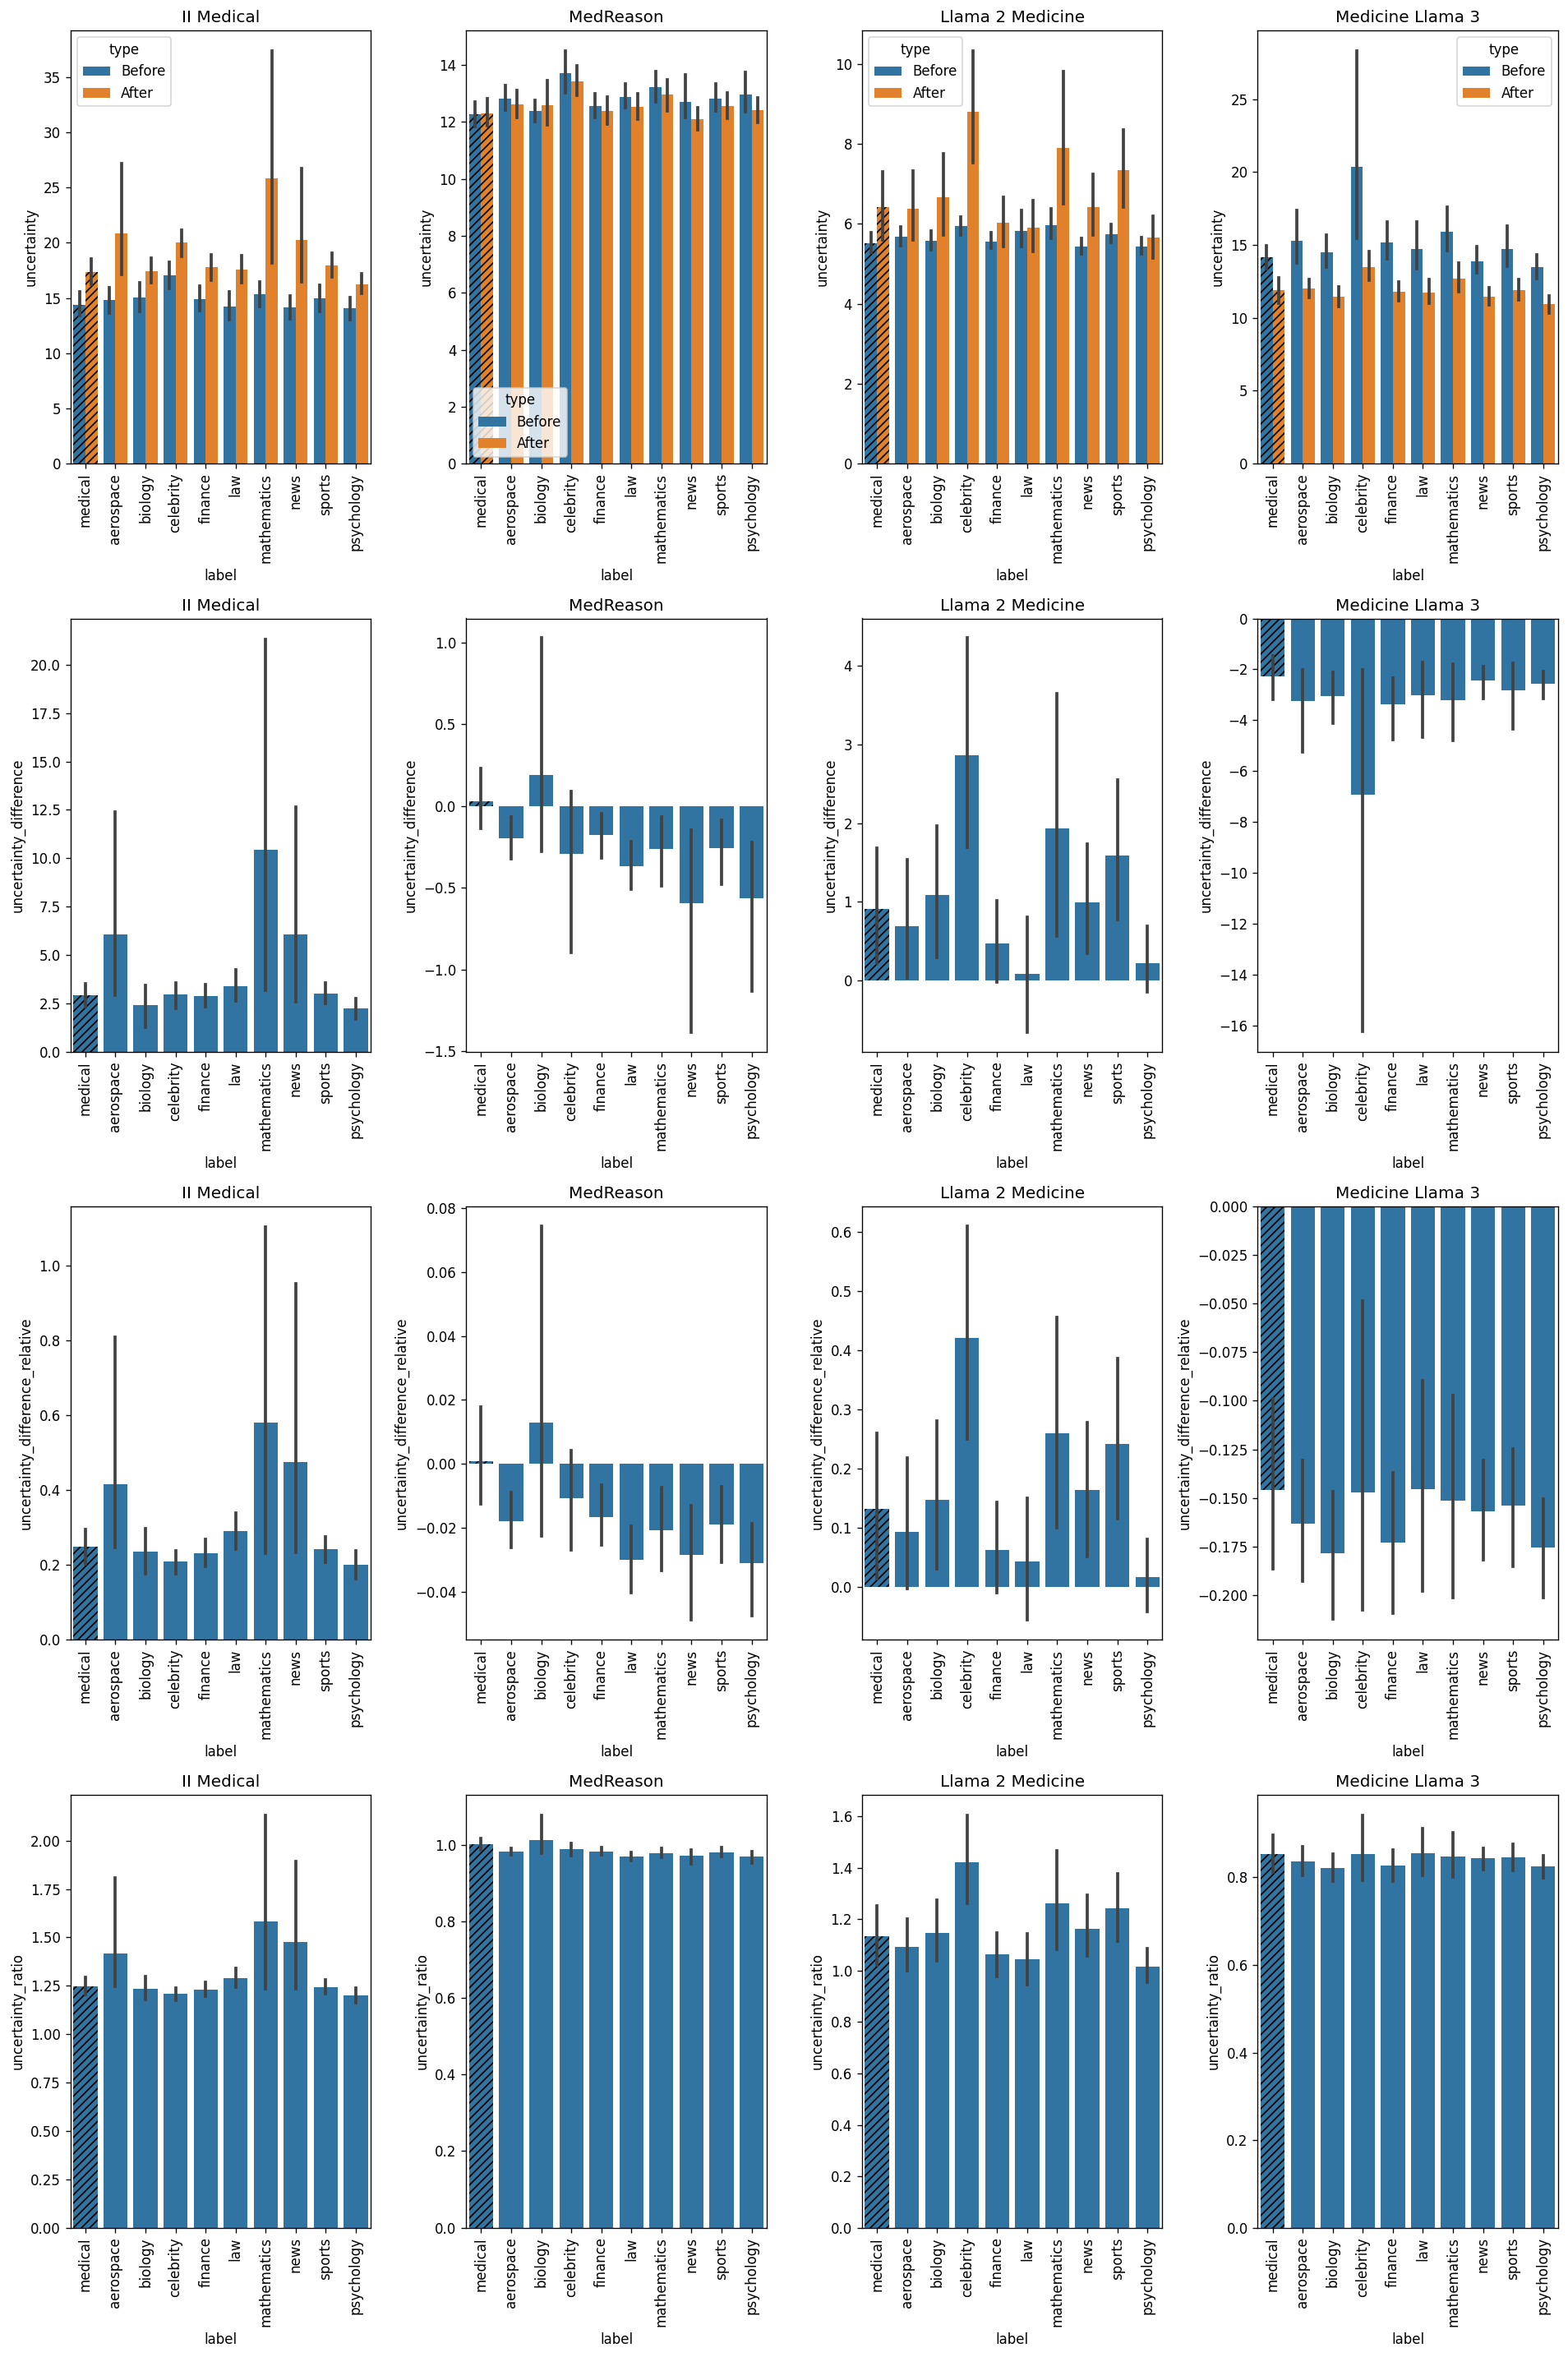

In [ ]:
# for combination in dfs:
#     for measure in dfs[combination]:
#         plot(dfs[combination][measure])

In [463]:
df_paths = {
    "AG-Pubmed 100": (
        "Medicine",
        {
            "II Medical": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl",
                ),
            },
            "MedReason": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2652_medreason_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2653_huatougpt_4bit_rephrase_ag-pubmed.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2652_medreason_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2653_huatougpt_4bit_rephrase_ag-pubmed.pkl",
                ),
            },
            "Llama 2 Medicine": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2614_medicine-chat_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2615_llama-2-chat_4bit_rephrase_ag-pubmed.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2614_medicine-chat_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2615_llama-2-chat_4bit_rephrase_ag-pubmed.pkl",
                ),
            },
            "Medicine Llama 3": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2644_medicine-llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
                    f"{data_dir}/full/domainspecific_results_2640_llama-3-8b_4bit_rephrase_ag-pubmed.pkl",
                ),
            },
        },
    ),
    "FineFineWeb 100": (
        "medical",
        {
            "II Medical": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2875_ii-medical_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2876_qwen2.5-7b-instruct_4bit_rephrase_finefineweb.pkl",
                ),
                "synonym": (
                    f"{data_dir}/full/domainspecific_results_3104_ii-medical_4bit_synonym_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3105_qwen2.5-7b-instruct_4bit_synonym_finefineweb.pkl",
                ),
                "random": (
                    f"{data_dir}/full/domainspecific_results_3068_ii-medical_4bit_random_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3069_qwen2.5-7b-instruct_4bit_random_finefineweb.pkl",
                ),
            },
            "MedReason": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2877_medreason_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2878_huatougpt_4bit_rephrase_finefineweb.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2877_medreason_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2878_huatougpt_4bit_rephrase_finefineweb.pkl",
                ),
                "synonym": (
                    f"{data_dir}/full/domainspecific_results_3066_medreason_4bit_synonym_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3067_huatougpt_4bit_synonym_finefineweb.pkl",
                ),
                "random": (
                    f"{data_dir}/full/domainspecific_results_3070_medreason_4bit_random_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3071_huatougpt_4bit_random_finefineweb.pkl",
                ),
            },
            "Llama 2 Medicine": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2941_medicine-chat_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2942_llama-2-chat_4bit_rephrase_finefineweb.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2941_medicine-chat_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2942_llama-2-chat_4bit_rephrase_finefineweb.pkl",
                ),
                "synonym": (
                    f"{data_dir}/full/domainspecific_results_3005_medicine-chat_4bit_synonym_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3006_llama-2-chat_4bit_synonym_finefineweb.pkl",
                ),
                "random": (
                    f"{data_dir}/full/domainspecific_results_3022_medicine-chat_4bit_random_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3023_llama-2-chat_4bit_random_finefineweb.pkl",
                ),
            },
            "Medicine Llama 3": {
                "input": (
                    f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl",
                ),
                "rephrase": (
                    f"{data_dir}/full/domainspecific_results_2939_medicine-llama-3-8b_4bit_rephrase_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_2940_llama-3-8b_4bit_rephrase_finefineweb.pkl",
                ),
                "synonym": (
                    f"{data_dir}/full/domainspecific_results_3003_medicine-llama-3-8b_4bit_synonym_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3004_llama-3-8b_4bit_synonym_finefineweb.pkl",
                ),
                "random": (
                    f"{data_dir}/full/domainspecific_results_3020_medicine-llama-3-8b_4bit_random_finefineweb.pkl",
                    f"{data_dir}/full/domainspecific_results_3021_llama-3-8b_4bit_random_finefineweb.pkl",
                ),
            },
        },
    ),
}

In [464]:
dfs = {}
for dataset, (trained_label, dataset_dfs) in df_paths.items():
    dfs[dataset] = (trained_label, {})
    for model, measures in dataset_dfs.items():
        num_measures = len(dataset_dfs)
        model_dfs = [None for _ in range(num_measures * 2 - 1)]
        for i, (measure, (path1, path2)) in enumerate(measures.items()):
            df1 = pd.read_pickle(path1)
            df2 = pd.read_pickle(path2)

            df1["id"] = df1["prompt"].apply(lambda x: hash(x))
            df2["id"] = df2["prompt"].apply(lambda x: hash(x))

            df1["rephrased_gradient"] = df1["rephrased_gradients"].apply(
                lambda rows: np.mean(rows)
            )
            df2["rephrased_gradient"] = df2["rephrased_gradients"].apply(
                lambda rows: np.mean(rows)
            )

            df1.rename(
                columns={
                    "rephrased_gradient": "uncertainty_after",
                    "rephrased_gradient_std": "std_after",
                },
                inplace=True,
            )
            df2.rename(
                columns={
                    "rephrased_gradient": "uncertainty_before",
                    "rephrased_gradient_std": "std_before",
                },
                inplace=True,
            )

            df = pd.merge(
                df1[
                    [
                        "prompt",
                        "label",
                        "uncertainty_after",
                        "std_after",
                        "id",
                    ]
                ],
                df2[["uncertainty_before", "std_before", "id"]],
                on="id",
            )

            df.dropna(
                subset=[
                    "uncertainty_before",
                    "uncertainty_after",
                    "std_before",
                    "std_after",
                ],
                inplace=True,
            )
            df[f"uncertainty_difference"] = (
                df[f"uncertainty_after"] - df[f"uncertainty_before"]
            )
            df[f"uncertainty_difference_relative"] = df[f"uncertainty_difference"] / df[
                f"uncertainty_before"
            ].replace([np.inf, -np.inf], np.nan)
            df[f"uncertainty_ratio"] = (
                df[f"uncertainty_after"] / df[f"uncertainty_before"]
            ).replace([np.inf, -np.inf], np.nan)

            df[f"std_difference"] = df[f"std_after"] - df[f"std_before"]
            df[f"std_difference_relative"] = df[f"std_difference"] / df[
                f"std_before"
            ].replace([np.inf, -np.inf], np.nan)
            df[f"std_ratio"] = (df[f"std_after"] / df[f"std_before"]).replace(
                [np.inf, -np.inf], np.nan
            )

            model_dfs[i] = df.drop(
                [
                    "std_before",
                    "std_after",
                    "std_difference",
                    "std_difference_relative",
                    "std_ratio",
                ],
                axis=1,
            )
            model_dfs[i]["measure"] = measure

            if measure != "input":
                model_dfs[num_measures - 1 + i] = df.drop(
                    [
                        "uncertainty_before",
                        "uncertainty_after",
                        "uncertainty_difference",
                        "uncertainty_difference_relative",
                        "uncertainty_ratio",
                    ],
                    axis=1,
                ).rename(
                    columns={
                        "std_before": "uncertainty_before",
                        "std_after": "uncertainty_after",
                        "std_difference": "uncertainty_difference",
                        "std_difference_relative": "uncertainty_difference_relative",
                        "std_ratio": "uncertainty_ratio",
                    }
                )
                model_dfs[num_measures - 1 + i]["measure"] = measure + "_std"

        dfs[dataset][1][model] = pd.concat(model_dfs, ignore_index=True)

In [465]:
def plot(dfs, dataset, trained_label):

    num_labels = max([df["label"].nunique() for _, df in dfs.items()])
    num_measures = max([df["measure"].nunique() for _, df in dfs.items()])
    num_models = len(dfs)

    measures = next(iter(dfs.values()))["measure"].unique()

    plt_width = 4
    plt_height = 6

    x_plots = num_models * num_measures
    y_plots = 4

    fig, axs = plt.subplots(
        y_plots,
        x_plots,
        figsize=(x_plots * plt_width, y_plots * plt_height),
        squeeze=False,
        constrained_layout=True,
    )

    for i, measure in enumerate(measures):
        for j, (model, full_df) in enumerate(dfs.items()):
            col_idx = i * num_models + j

            df = full_df[full_df["measure"] == measure].drop("measure", axis=1)

            df_melted = df[["label", "uncertainty_before", "uncertainty_after"]].melt(
                id_vars=["label"],
                value_vars=["uncertainty_before", "uncertainty_after"],
                var_name="type",
                value_name="uncertainty",
            )
            df_melted["type"] = df_melted["type"].map(
                {
                    "uncertainty_before": "Before",
                    "uncertainty_after": "After",
                }
            )

            sns.barplot(
                data=df_melted,
                x="label",
                y="uncertainty",
                hue="type",
                ax=axs[0][col_idx],
            )

            sns.barplot(
                data=df,
                x="label",
                y="uncertainty_difference",
                ax=axs[1][col_idx],
            )
            sns.barplot(
                data=df,
                x="label",
                y="uncertainty_difference_relative",
                ax=axs[2][col_idx],
            )
            sns.barplot(
                data=df,
                x="label",
                y="uncertainty_ratio",
                ax=axs[3][col_idx],
            )

            # Get the x-tick positions and labels
            for row_idx, ax in enumerate(axs.T[col_idx]):
                x_ticks = ax.get_xticks()
                x_labels = [text.get_text() for text in ax.get_xticklabels()]

                # Find the position of the trained_label
                trained_pos = -1
                for pos, label in enumerate(x_labels):
                    if label == trained_label:
                        trained_pos = pos
                        break

                if trained_pos != -1:
                    # For each bar, check if its center is close to the trained_label tick position
                    for bar in ax.patches:
                        # Calculate bar center
                        bar_center = bar.get_x() + bar.get_width() / 2

                        # If bar center is close to the trained_label tick, hatch it
                        if abs(bar_center - x_ticks[trained_pos]) < 0.5:
                            bar.set_hatch("////")

                ax.tick_params(axis="x", labelrotation=90)
                ax.set_title(f"{model} - {measure}")

    fig.suptitle(dataset, fontsize=16)


def t_tests(dfs, metric):
    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]
        other_groups = df[df["label"] != trained_label][metric]

        t_stat, p_value = ttest_ind(trained_group, other_groups, equal_var=False)

        print(
            f"{name:<10} {trained_label} vs Others T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
        )

    print()

    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]

        labels = df["label"].unique()

        for label in labels:
            if label != trained_label:
                other_group = df[df["label"] == label][metric]
                t_stat, p_value = ttest_ind(trained_group, other_group, equal_var=False)
                print(
                    f"{name:<10} {trained_label} vs {label:<10} T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
                )

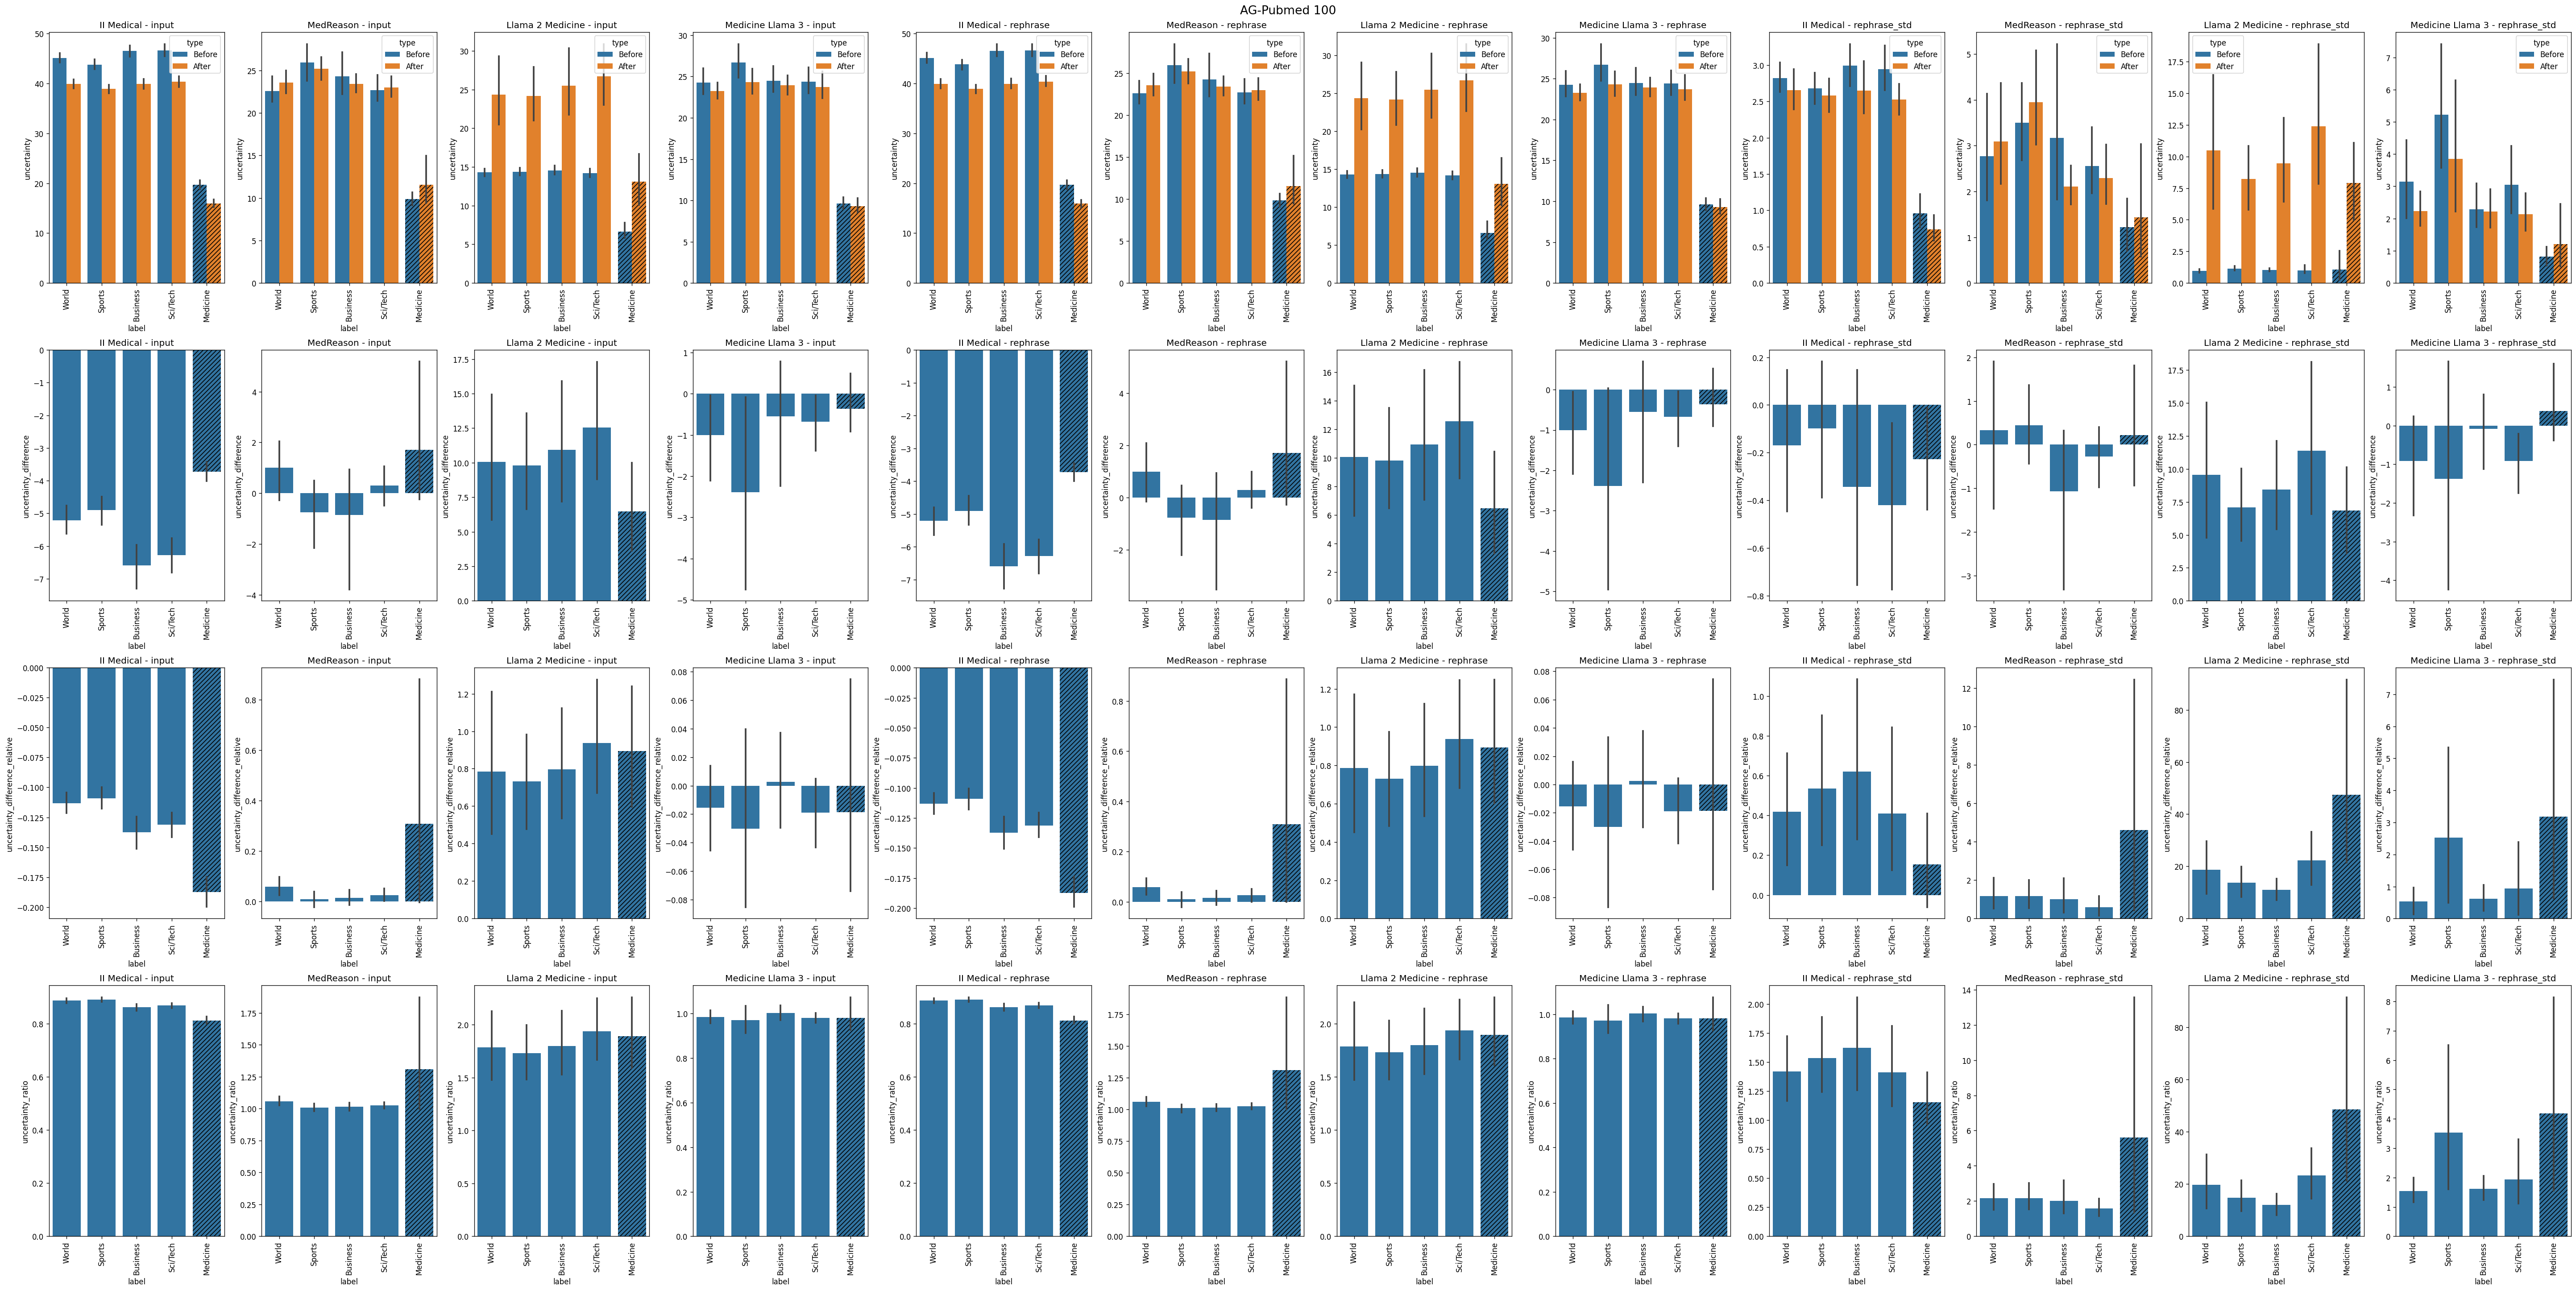

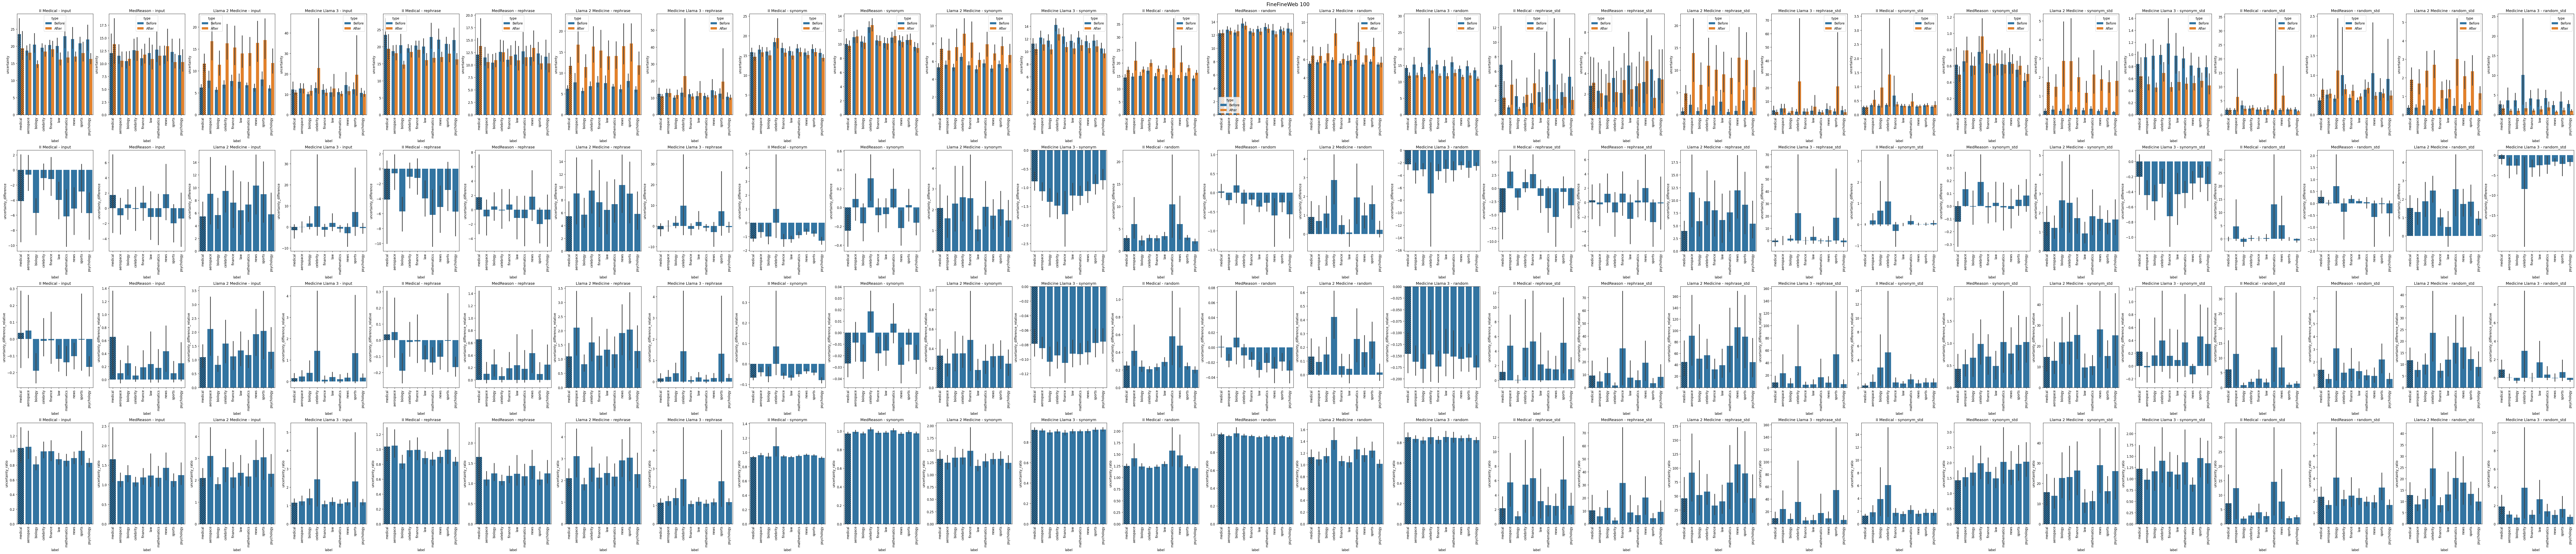

In [466]:
for dataset, dataset_dfs in dfs.items():
    plot(dataset_dfs[1], dataset, dataset_dfs[0])

In [467]:
for combination in dfs:
    for measure in dfs[combination]:
        t_tests(dfs[combination][measure], "uncertainty_difference")

TypeError: tuple indices must be integers or slices, not str

In [ ]:
for combination in dfs:
    for measure in dfs[combination]:
        t_tests(dfs[combination][measure], "uncertainty_difference_relative")

II Medical Medicine vs Others T-statistic:      -8.8401, P-value: 0.0000
MedReason  Medicine vs Others T-statistic:       1.0369, P-value: 0.3024
Llama 2 Medicine Medicine vs Others T-statistic:       0.4259, P-value: 0.6708
Medicine Llama 3 Medicine vs Others T-statistic:      -0.0749, P-value: 0.9404

II Medical Medicine vs World      T-statistic:      -9.0518, P-value: 0.0000
II Medical Medicine vs Sports     T-statistic:      -9.6423, P-value: 0.0000
II Medical Medicine vs Business   T-statistic:      -5.2218, P-value: 0.0000
II Medical Medicine vs Sci/Tech   T-statistic:      -6.5790, P-value: 0.0000
MedReason  Medicine vs World      T-statistic:       0.9198, P-value: 0.3600
MedReason  Medicine vs Sports     T-statistic:       1.1014, P-value: 0.2735
MedReason  Medicine vs Business   T-statistic:       1.0802, P-value: 0.2827
MedReason  Medicine vs Sci/Tech   T-statistic:       1.0420, P-value: 0.3000
Llama 2 Medicine Medicine vs World      T-statistic:       0.4336, P-value: 0.6

In [ ]:
for combination in dfs:
    for measure in dfs[combination]:
        t_tests(dfs[combination][measure], "uncertainty_ratio")

II Medical Medicine vs Others T-statistic:      -8.8401, P-value: 0.0000
MedReason  Medicine vs Others T-statistic:       1.0369, P-value: 0.3024
Llama 2 Medicine Medicine vs Others T-statistic:       0.4259, P-value: 0.6708
Medicine Llama 3 Medicine vs Others T-statistic:      -0.0749, P-value: 0.9404

II Medical Medicine vs World      T-statistic:      -9.0518, P-value: 0.0000
II Medical Medicine vs Sports     T-statistic:      -9.6423, P-value: 0.0000
II Medical Medicine vs Business   T-statistic:      -5.2218, P-value: 0.0000
II Medical Medicine vs Sci/Tech   T-statistic:      -6.5790, P-value: 0.0000
MedReason  Medicine vs World      T-statistic:       0.9198, P-value: 0.3600
MedReason  Medicine vs Sports     T-statistic:       1.1014, P-value: 0.2735
MedReason  Medicine vs Business   T-statistic:       1.0802, P-value: 0.2827
MedReason  Medicine vs Sci/Tech   T-statistic:       1.0420, P-value: 0.3000
Llama 2 Medicine Medicine vs World      T-statistic:       0.4336, P-value: 0.6